In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import pickle5 as pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from yahooquery import Ticker

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

np.random.seed(134)

pd.set_option('display.max_columns', None)  # or 1000
# pd.options.display.max_rows = 999
# pd.get_option("display.max_rows")

plt.style.use('ggplot')
sm, med, lg = 10, 15, 20
plt.rc("font", size=sm)  # controls default text sizes
plt.rc("axes", titlesize=med)  # fontsize of the axes title
plt.rc("axes", labelsize=med)  # fontsize of the x & y labels
plt.rc("xtick", labelsize=sm)  # fontsize of the tick labels
plt.rc("ytick", labelsize=sm)  # fontsize of the tick labels
plt.rc("legend", fontsize=sm)  # legend fontsize
plt.rc("figure", titlesize=lg)  # fontsize of the figure title
plt.rc("axes", linewidth=2)  # linewidth of plot lines
plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["figure.dpi"] = 100

In [39]:
day = '2021-12-21'
month = str(day)[:7]
year = str(day)[:4]

path9 = Path(f"/home/gdp/russell_3k/data/recommenders/{year}/{month}/{day}/")
path5 = Path(path9 / "recommender_05_return_dataFrame.pkl")

with open(path5, "rb") as fh:
    df = pickle.load(fh)
    
df.reset_index(inplace=True)

<IPython.core.display.Javascript object>

In [40]:
port_tics = list(df['ticker'])

hammerTime = Ticker(
    port_tics,
    asynchronous=True,
    formatted=False,
    backoff_factor=0.34,
    progress=True,
    validate=True,
    verify=True,
)
hammer_hist = hammerTime.history(period='1y').reset_index().set_index('date')
hammer_hist.index = pd.to_datetime(hammer_hist.index)
hammer_hist = hammer_hist.rename(columns={'symbol': 'ticker'})
bulk_files = pd.DataFrame()
for i in port_tics:
    try:
        z = pd.DataFrame(hammer_hist[hammer_hist['ticker'] == i]['adjclose'])
        bulk_files[i] = z
    except:
        print(f"failed ticker {i}")
        port_tics.remove(i)                 
bulk_files = bulk_files.dropna(axis='columns')
bulk_files.index = pd.to_datetime(bulk_files.index)  
bulk_files = pd.DataFrame(bulk_files.reindex(sorted(bulk_files.columns), axis=1).copy())

100%|██████████| 90/90 [00:01<00:00, 53.54it/s]


In [43]:
d={}
for i in bulk_files.columns:
    ret = (bulk_files[i].iloc[-1] - bulk_files[i].iloc[0]) / bulk_files[i].iloc[0]
    d[i] = ret
    
new_lst = []
for i in df['ticker']:
    if i in d.keys():
        new_lst.append(d.get(i))
    else:
        new_lst.append(0.0)
df['ret'] = new_lst    

In [44]:
df['goal'] = df['ret'] > 0.1

In [45]:
df = df.reset_index()

In [46]:
try:
    del df['ticker']
    del df['company']
    del df['sector']
    del df['industry']
    del df['country']
    del df['earnings_date']
    del df['ipo_date']
except Exception:
    pass

In [47]:
df

,index,no,market_cap,pe,forward_pe,peg,ps,pb,pcash,pfree_cash_flow,dividend_yield,payout_ratio,eps_ttm,eps_growth_this_year,eps_growth_next_year,eps_growth_past_5_years,eps_growth_next_5_years,sales_growth_past_5_years,eps_growth_quarter_over_quarter,sales_growth_quarter_over_quarter,shares_outstanding,shares_float,insider_ownership,insider_transactions,institutional_ownership,institutional_transactions,float_short,short_ratio,return_on_assets,return_on_equity,return_on_investment,current_ratio,quick_ratio,lt_debtequity,total_debtequity,gross_margin,operating_margin,profit_margin,performance_week,performance_month,performance_quarter,performance_half_year,performance_year,performance_ytd,beta,average_true_range,volatility_week,volatility_month,20day_simple_moving_average,50day_simple_moving_average,200day_simple_moving_average,50day_high,50day_low,52week_high,52week_low,relative_strength_index_14,change_from_open,gap,ar,average_volume,relative_volume,price,change,volume,target_price,afterhours_close,afterhours_change,analyst_recom,rs_rating,returns_multiple,current_price,day_ma_20,day_ma_50,day_ma_200,low_52_week,high_52_week,sentiment_score,est_gl,my_score,ret,goal
0,0,23,2639.44,5.22,6.88,0.52,0.69,0.99,0.00,3.58,0.00,0.0,17.07,218.9,-26.13,115.4,10.00,12.0,40.7,25.5,29.02,27.16,0.40,-33.73,0.0,1.14,13.77,6.62,8.2,20.5,7.8,0.8,0.8,0.64,0.90,57.0,16.9,13.2,1.98,-0.58,20.46,29.56,60.93,63.44,1.12,2.82,3.45,3.13,0.57,4.34,20.49,-6.17,16.23,-6.17,77.50,55.82,0.03,1.28,2.0,565.43,0.81,89.14,1.32,458852.0,105.57,89.14,0.00,69.0,87.0,1.26,89.139999,88.47,85.61,74.14,50.22,95.00,27.0,18.43,61.000000,0.260967,True
1,1,79,2131.07,28.86,17.84,1.44,3.68,4.28,7.86,21.64,0.00,0.0,2.26,190.8,36.73,24.7,20.00,9.5,155.8,60.1,33.54,32.68,2.50,-6.56,89.4,0.84,2.23,1.96,11.8,15.7,9.8,4.2,2.7,0.09,0.09,43.2,16.4,13.4,2.87,4.36,34.70,69.06,119.91,124.21,1.48,3.29,6.02,5.35,1.74,10.78,40.65,-6.44,39.36,-6.44,132.93,55.44,0.85,3.06,1.8,373.21,0.79,65.29,3.93,296344.0,79.33,65.29,0.00,75.0,96.0,1.79,65.290001,64.26,59.27,46.56,28.03,69.79,20.0,21.50,63.666667,0.699371,True
2,2,328,7148.66,0.00,102.19,0.00,23.53,13.62,15.62,297.86,0.00,0.0,-0.83,-27.3,21.88,-22.5,0.00,-6.8,103.9,64.3,36.79,34.48,5.20,-4.57,84.0,3.63,3.60,1.56,-4.9,-5.9,-13.4,6.8,6.2,0.00,0.00,62.1,-10.3,-9.8,0.30,3.77,19.12,87.37,119.61,113.24,1.13,15.38,10.38,8.19,1.30,4.90,52.76,-13.97,32.46,-13.97,137.07,51.78,2.59,3.42,2.3,797.26,0.75,195.80,6.10,597882.0,218.00,195.80,0.00,59.0,96.0,1.69,195.800003,194.00,187.55,128.61,82.59,227.59,15.0,11.34,56.666667,0.059689,False
3,3,346,5634.57,26.10,19.55,1.35,1.73,5.49,41.13,25.83,0.00,0.0,4.59,-38.1,-13.35,-2.4,19.35,10.3,181.6,59.1,47.74,46.88,0.30,-15.32,96.6,-0.10,2.06,1.91,8.5,23.7,7.6,1.4,1.4,0.81,0.81,33.3,10.4,6.8,8.71,1.11,4.73,26.69,75.15,75.69,0.26,4.56,4.89,3.94,5.56,10.58,21.95,-3.78,28.47,-3.78,79.78,63.42,-0.02,0.06,1.7,506.08,0.93,119.91,0.04,469654.0,133.33,119.91,0.00,78.0,91.0,1.38,119.910004,113.58,108.44,98.54,67.04,124.62,16.0,11.19,61.666667,0.325523,True
4,4,449,5492.31,107.99,47.80,6.69,3.75,9.40,37.57,53.12,0.00,0.0,0.42,-56.0,20.31,32.0,16.14,5.2,-16.0,11.0,121.25,119.12,0.30,-30.94,0.0,-0.77,1.58,2.33,2.8,9.6,3.7,1.7,1.3,1.26,1.30,31.5,4.2,3.5,-0.86,-7.55,15.31,37.54,77.70,66.90,1.84,1.82,4.60,3.83,-1.82,3.00,27.55,-8.81,21.31,-8.81,104.68,49.60,3.47,0.74,2.2,807.48,0.89,45.03,4.24,721868.0,48.70,45.03,0.00,63.0,90.0,1.34,45.029999,45.76,43.87,35.40,22.00,49.38,14.0,8.15,55.666667,0.745440,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,7539,988.76,16.43,14.40,1.37,4.53,1.46,2.05,10.41,0.00,0.0,1.79,-31.1,23.98,10.3,12.00,21.0,104.9,18.9,31.36,30.52,2.90,-0.37,78.3,0.40,2.07,1.34,0.5,9.3,22.5,0.0,0.0,0.15,0.15,0.0,75.1,25.8,0

In [31]:
def clean(df1):
    temp = []
    for i in list(df1):
        if type(i) == float:
            temp.append(i)
        elif type(i) == int:
            temp.append(i)
        else:
            string = i[:-1]
            temp.append(float(string))
    return temp    



def up10_at_all_check(df):
    temp_lst1 = []
    temp_lst2 = []

    for i in df['up10_1mo']:
        if i == True:
            temp_lst1.append(1.0)
        else:
            temp_lst1.append(0.0)

    for i in df['up10_2mo']:
        if i == True:
            temp_lst2.append(1.0)
        else:
            temp_lst2.append(0.0)

    df['up10_1mo_score'] = temp_lst1
    df['up10_2mo_score'] = temp_lst2
    df['up10_total_score'] = df['up10_1mo_score'] + df['up10_2mo_score']
    df['up10_total'] = df['up10_total_score'] != 0.0
    del df['up10_1mo_score']    
    del df['up10_2mo_score']
    del df['up10_total_score']
    return df    



def build_dataframe():
    past = pd.read_csv("data/finviz/2021-12/2021-12-02/finviz.csv").set_index('Ticker')
    present = pd.read_csv('data/finviz/2022-01/2022-01-03/finviz.csv').set_index('Ticker')
    future = pd.read_csv('data/finviz/2022-02/2022-02-04/finviz.csv').set_index('Ticker')

    past = past.rename(columns={'Price': 'past_price'})   
    present = present.rename(columns={'Price': 'present_price'}) 
    future = future.rename(columns={'Price': 'future_price'})    


    n0 = pd.DataFrame(past.copy()).reset_index()
    n1 = pd.DataFrame(present['present_price'].copy()).reset_index()
    n3 = pd.DataFrame(future['future_price'].copy()).reset_index()

    df0 = n0.merge(n1, how='left', on='Ticker')
    df = df0.merge(n3, how='left', on='Ticker')

    df['return_1mo'] = ((df['present_price'] - df['past_price']) / df['past_price']) * 100
    df['return_2mo'] = ((df['future_price'] - df['past_price']) / df['past_price']) * 100
    df['up10_1mo'] = df['return_1mo'] > 9.99
    df['up10_2mo'] = df['return_2mo'] > 9.99

    df = up10_at_all_check(df)

    data = pd.DataFrame(df.copy()).fillna(0.0)
    data.columns = [c.lower() for c in data.columns]
    data.columns = [c.replace(' ', '_') for c in data.columns]
    data.columns = [c.replace('(', '') for c in data.columns]
    data.columns = [c.replace(')', '') for c in data.columns]
    data.columns = [c.replace('-', '_') for c in data.columns]
    data.columns = [c.replace('/', '_') for c in data.columns]
    data.columns = [c.replace('.', '') for c in data.columns]

    df = pd.DataFrame(
        data[
            [
                'no', 'ticker', 'company', 'sector', 'industry', 'country',
                'market_cap', 'p_e', 'forward_p_e', 'peg', 'p_s', 'p_b', 'p_cash', 'p_free_cash_flow', 'dividend_yield', 'payout_ratio', 
                'eps_ttm', 'eps_growth_this_year', 'eps_growth_next_year', 'eps_growth_past_5_years', 'eps_growth_next_5_years', 
                'sales_growth_past_5_years', 'eps_growth_quarter_over_quarter', 'sales_growth_quarter_over_quarter', 'shares_outstanding', 
                'shares_float', 'insider_ownership', 'insider_transactions', 'institutional_ownership', 'institutional_transactions', 
                'float_short', 'short_ratio', 'return_on_assets', 'return_on_equity', 'return_on_investment', 'current_ratio', 'quick_ratio', 
                'lt_debt_equity', 'total_debt_equity', 'gross_margin', 'operating_margin', 'profit_margin', 'performance_week', 
                'performance_month', 'performance_quarter', 'performance_half_year', 'performance_year', 'performance_ytd', 'beta', 
                'average_true_range', 'volatility_week', 'volatility_month', '20_day_simple_moving_average', '50_day_simple_moving_average', 
                '200_day_simple_moving_average', '50_day_high', '50_day_low', '52_week_high', '52_week_low', 'relative_strength_index_14', 
                'change_from_open', 'gap', 'analyst_recom', 'average_volume', 'relative_volume', 'past_price', 'change', 'volume', 
                'earnings_date', 'ipo_date', 'after_hours_change',
                'target_price', 'after_hours_close', 'present_price', 'future_price', 
                'return_1mo', 'return_2mo', 'up10_1mo', 'up10_2mo', 'up10_total',
            ]
        ]
    )
    return df    



def build_dataframe2():
    df = build_dataframe()

    df = pd.DataFrame(
        df[
            [
                'no',
                # 'ticker',  # 'company', 
                'sector', 
                'industry', 
                'country',
                'market_cap', 'p_e', 'forward_p_e', 'peg', 'p_s', 'p_b', 'p_cash', 'p_free_cash_flow', 'dividend_yield', 'payout_ratio', 
                'eps_ttm', 'eps_growth_this_year', 'eps_growth_next_year', 'eps_growth_past_5_years', 'eps_growth_next_5_years', 
                'sales_growth_past_5_years', 'eps_growth_quarter_over_quarter', 'sales_growth_quarter_over_quarter', 'shares_outstanding', 
                'shares_float', 'insider_ownership', 'insider_transactions', 'institutional_ownership', 'institutional_transactions', 
                'float_short', 'short_ratio', 'return_on_assets', 'return_on_equity', 'return_on_investment', 'current_ratio', 'quick_ratio', 
                'lt_debt_equity', 'total_debt_equity', 'gross_margin', 'operating_margin', 'profit_margin', 'performance_week', 
                'performance_month', 'performance_quarter', 'performance_half_year', 'performance_year', 'performance_ytd', 'beta', 
                'average_true_range', 'volatility_week', 'volatility_month', '20_day_simple_moving_average', '50_day_simple_moving_average', 
                '200_day_simple_moving_average', '50_day_high', '50_day_low', '52_week_high', '52_week_low', 'relative_strength_index_14', 
                'change_from_open', 'gap', 'analyst_recom', 'average_volume', 'relative_volume', 'past_price', 'change',  'volume', 
                # 'earnings_date', 'ipo_date', 
                'after_hours_change', 'target_price', 'after_hours_close', 'present_price', 'future_price', 
                'return_1mo', 'return_2mo', 'up10_1mo', 'up10_2mo', 'up10_total',
            ]
        ]
    ).fillna(0.0)

    df = df.round(4)

    del df['return_1mo']
    del df['return_2mo']
    del df['up10_1mo']
    del df['up10_2mo']
    del df['past_price']
    del df['present_price']
    del df['future_price']

    
    X = df.values

    le_sex = preprocessing.LabelEncoder()
    le_sex.fit([
        'Real Estate', 'Energy', 'Consumer Cyclical', 'Technology', 'Communication Services', 'Healthcare', 
        'Utilities', 'Industrials', 'Basic Materials', 'Consumer Defensive', 'Financial'
    ])
    X[:,1] = le_sex.transform(X[:,1]) 


    le_BP = preprocessing.LabelEncoder()
    le_BP.fit(
        [
            'REIT - Diversified', 'Financial Data & Stock Exchanges', 'Solar', 'REIT - Retail', 'Industrial Distribution', 'Resorts & Casinos', 
            'Marine Shipping', 'Insurance - Reinsurance', 'Furnishings, Fixtures & Appliances', 'Oil & Gas Midstream', 'Medical Care Facilities', 
            'Aerospace & Defense', 'Specialty Industrial Machinery', 'Insurance - Property & Casualty', 'Department Stores', 'REIT - Hotel & Motel', 
            'Gold', 'Shell Companies', 'Electronic Gaming & Multimedia', 'Scientific & Technical Instruments', 'Confectioners', 'Exchange Traded Fund', 
            'Advertising Agencies', 'Capital Markets', 'Utilities - Diversified', 'Paper & Paper Products', 'Chemicals', 'Residential Construction', 
            'Oil & Gas Equipment & Services', 'Conglomerates', 'Travel Services', 'Drug Manufacturers - General', 'Internet Retail', 'Publishing', 
            'Grocery Stores', 'Closed-End Fund - Debt', 'Entertainment', 'Medical Distribution', 'Rental & Leasing Services', 'Beverages - Brewers', 
            'Home Improvement Retail', 'Tools & Accessories', 'Textile Manufacturing', 'Oil & Gas Drilling', 'REIT - Specialty', 'Packaged Foods', 
            'Luxury Goods', 'Recreational Vehicles', 'Software - Infrastructure', 'Medical Instruments & Supplies', 'Auto Manufacturers', 
            'Internet Content & Information', 'Trucking', 'Insurance Brokers', 'Infrastructure Operations', 'Business Equipment & Supplies', 
            'Security & Protection Services', 'Staffing & Employment Services', 'Pollution & Treatment Controls', 'REIT - Mortgage', 'REIT - Industrial', 
            'Apparel Manufacturing', 'Apparel Retail', 'Closed-End Fund - Equity', 'Oil & Gas E&P', 'Food Distribution', 'Restaurants', 'Thermal Coal', 
            'Waste Management', 'Leisure', 'Metal Fabrication', 'Specialty Retail', 'Other Precious Metals & Mining', 'Aluminum', 'Footwear & Accessories', 
            'Communication Equipment', 'Computer Hardware', 'Farm Products', 'Other Industrial Metals & Mining', 'Real Estate - Diversified', 
            'Health Information Services', 'Building Materials', 'Uranium', 'REIT - Residential', 'Utilities - Regulated Electric', 'Specialty Chemicals', 
            'Building Products & Equipment', 'Airlines', 'Broadcasting', 'Discount Stores', 'Real Estate - Development', 'Beverages - Non-Alcoholic', 
            'Medical Devices', 'Biotechnology', 'Electronics & Computer Distribution', 'Silver', 'Electrical Equipment & Parts', 'Steel', 'Drug Manufacturers - Specialty & Generic', 
            'Engineering & Construction', 'Insurance - Diversified', 'Household & Personal Products', 'Healthcare Plans', 'Oil & Gas Refining & Marketing', 
            'Information Technology Services', 'Railroads', 'Tobacco', 'Utilities - Regulated Gas', 'Telecom Services', 'Lumber & Wood Production', 'Auto Parts', 
            'Auto & Truck Dealerships', 'Semiconductor Equipment & Materials', 'Diagnostics & Research', 'Banks - Diversified', 'Real Estate Services', 
            'Insurance - Life', 'Pharmaceutical Retailers', 'Gambling', 'Oil & Gas Integrated', 'Asset Management', 'Lodging', 'REIT - Office', 'Financial Conglomerates', 
            'Insurance - Specialty', 'Consulting Services', 'Education & Training Services', 'REIT - Healthcare Facilities', 'Banks - Regional', 'Mortgage Finance', 
            'Coking Coal', 'Closed-End Fund - Foreign', 'Specialty Business Services', 'Farm & Heavy Construction Machinery', 'Integrated Freight & Logistics', 
            'Software - Application', 'Credit Services', 'Electronic Components', 'Airports & Air Services', 'Copper', 'Consumer Electronics', 'Agricultural Inputs', 
            'Utilities - Independent Power Producers', 'Utilities - Renewable', 'Packaging & Containers', 'Beverages - Wineries & Distilleries', 
            'Utilities - Regulated Water', 'Personal Services', 'Semiconductors'
        ]
    )
    X[:,2] = le_BP.transform(X[:,2])


    le_Chol = preprocessing.LabelEncoder()
    le_Chol.fit(
        [
            'Luxembourg', 'United Kingdom', 'Sweden', 'France', 'United Arab Emirates', 'Norway', 'Bermuda', 'Uruguay', 'Panama', 'Costa Rica', 'Belgium', 
            'Russia', 'Bahamas', 'Brazil', 'South Korea', 'Taiwan', 'Japan', 'Ireland', 'Canada', 'Denmark', 'Mexico', 'Argentina', 'Colombia', 'Turkey', 
            'Netherlands', 'South Africa', 'Peru', 'Germany', 'Italy', 'USA', 'India', 'Finland', 'Philippines', 'Indonesia', 'Hong Kong', 'China', 'Monaco', 
            'Kazakhstan', 'Switzerland', 'Chile', 'Malaysia', 'Malta', 'Cyprus', 'Cayman Islands', 'Greece', 'Spain', 'Singapore', 'Israel', 'Australia'
        ]
    )
    X[:,3] = le_Chol.transform(X[:,3]) 

    df = pd.DataFrame(X)
    df.columns = [
        'no',
        # 'ticker',  # 'company', 
        'sector', 
        'industry', 
        'country',
        'market_cap', 'p_e', 'forward_p_e', 'peg', 'p_s', 'p_b', 'p_cash', 'p_free_cash_flow', 'dividend_yield', 'payout_ratio', 
        'eps_ttm', 'eps_growth_this_year', 'eps_growth_next_year', 'eps_growth_past_5_years', 'eps_growth_next_5_years', 
        'sales_growth_past_5_years', 'eps_growth_quarter_over_quarter', 'sales_growth_quarter_over_quarter', 'shares_outstanding', 
        'shares_float', 'insider_ownership', 'insider_transactions', 'institutional_ownership', 'institutional_transactions', 
        'float_short', 'short_ratio', 'return_on_assets', 'return_on_equity', 'return_on_investment', 'current_ratio', 'quick_ratio', 
        'lt_debt_equity', 'total_debt_equity', 'gross_margin', 'operating_margin', 'profit_margin', 'performance_week', 
        'performance_month', 'performance_quarter', 'performance_half_year', 'performance_year', 'performance_ytd', 'beta', 
        'average_true_range', 'volatility_week', 'volatility_month', '20_day_simple_moving_average', '50_day_simple_moving_average', 
        '200_day_simple_moving_average', '50_day_high', '50_day_low', '52_week_high', '52_week_low', 'relative_strength_index_14', 
        'change_from_open', 'gap', 'analyst_recom', 'average_volume', 'relative_volume', 'after_hours_change', 'change', 'volume',
        'target_price', 'after_hours_close', 'up10_total',
        # 'earnings_date', 'ipo_date', 
        # 'past_price', 'present_price', 'future_price', 'return_1mo', 'return_2mo', 'up10_1mo', 'up10_2mo', 
    ]

    df.to_csv('/home/gdp/russell_3k/data/bin/short_save.csv')
    df = pd.read_csv("/home/gdp/russell_3k/data/bin/short_save.csv")
    del df['Unnamed: 0']

    for i in df.columns[:-1]:
        df[i] = clean(df[i])    

    return df      


def setup_randomForest(df):
    y = df.pop('goal').values
    X = df.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.41, random_state=13, shuffle=False)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    y_predict = rf.predict(X_test)
    print('\n', '> Confusion Matrix:', f"\n{'_'*25}", '\n', confusion_matrix(y_test, y_predict), '\n\n')

    print('> METRICS:', f"\n{'_'*25}")
    print("- score:", round(rf.score(X_test, y_test)*100,4))

    rf = RandomForestClassifier(n_estimators=65, oob_score=True)
    rf.fit(X_train, y_train)
    print("- out of bag score:", rf.oob_score_)

    print("- precision:", round(precision_score(y_test, y_predict)*100,4))
    print("- recall:", round(recall_score(y_test, y_predict)*100,4))
    print("- accuracy score:", rf.score(X_test, y_test))
    
    feature_importances = np.argsort(rf.feature_importances_)
    print("\n> TOP 5:", f"\n{'_'*25}")
    c = 0
    for i in list(df.columns[feature_importances[-1:-6:-1]]):
        c += 1
        print(f"{c}) {i}")
    print('\n')

    return X, y, X_train, X_test, y_train, y_test, rf, y_predict



def top_features():     
    n = 57                                                                         # top 15 features OR all features   
    importances = rf.feature_importances_[:n]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    features = list(df.columns[indices])
    score_keeper = 0.0

    print("> Feature ranking:", f"\n{'_'*25}")                                                      # Print the feature ranking
    for f in range(n):
        print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))
        score_keeper += importances[indices[f]]
    print('\n', f">>> Total Variance Accounted For [{round((score_keeper*100),4)} %]", '\n')

    fig, ax = plt.subplots()                                                                        # Plot the feature importances of the forest
    ax.bar(
        range(n), 
        importances[indices], 
        yerr=std[indices], 
        color="r",
        align="center",
    )
    ax.set_xticks(range(n))
    ax.set_xticklabels(features, rotation = 90)
    ax.set_xlim([-1, n])
    ax.set_xlabel("importance")
    ax.set_title("Feature Importances")
    plt.legend(["importance", "std"], loc="lower right")
    plt.show();



def plot_feature_importance(model_type='RANDOM FOREST'):
    n = 25 # len(df.columns)-1                                                                      # top 15 features OR all features   
    importances = rf.feature_importances_[:n]                                                       # Create arrays from feature importance and feature names
    feature_importance = np.array(importances)
    indices = np.argsort(importances)[::-1]
    feature_names = list(df.columns[indices])
    data={'feature_names':feature_names, 'feature_importance':feature_importance}                   # Create a DataFrame using a Dictionary
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)                     # Sort the DataFrame in order decreasing feature importance

    fig, ax = plt.subplots()                                                                        # Define size of bar plot
    sns.barplot(
        x=fi_df['feature_importance'], 
        y=fi_df['feature_names'],
        )
    plt.title(model_type + 'FEATURE IMPORTANCE')                                                    # Add chart labels
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show();



def calc_and_plot_trees():
    num_trees = range(5, 100, 5)
    accuracies = []
    for n in num_trees:
        tot = 0
        for i in range(5):
            rf = RandomForestClassifier(n_estimators=n)
            rf.fit(X_train, y_train)
            tot += rf.score(X_test, y_test)
        accuracies.append(tot / 5)

    fd = pd.DataFrame()
    fd['num_trees'] = num_trees
    fd['accuracies'] = accuracies
    x1 = fd[fd["accuracies"] == fd["accuracies"].max()]["num_trees"]
    y1 = fd['accuracies'].max()

    fig, ax = plt.subplots()
    ax.plot(num_trees, accuracies)
    ax.plot(x1, y1, color="green", marker="*", ms=25, label="Max Trees / Max Accuracy")
    ax.set_xlabel("Number of Trees")
    ax.set_ylabel("Accuracy")
    ax.set_title('Accuracy vs Num Trees')
    plt.legend(loc="lower right")
    plt.show()
    return int(x1), y1



def calc_and_plot_features(df):
    num_features = range(1, len(df.columns) + 1)
    accuracies = []
    for n in num_features:
        tot = 0
        for i in range(5):
            rf = RandomForestClassifier(max_features=n)
            rf.fit(X_train, y_train)
            tot += rf.score(X_test, y_test)
        accuracies.append(tot / 5)

    fd = pd.DataFrame()
    fd['num_features'] = num_features
    fd['accuracies'] = accuracies
    x1 = fd[fd["accuracies"] == fd["accuracies"].max()]["num_features"]
    y1 = fd['accuracies'].max()  

    fig, ax = plt.subplots()
    ax.plot(num_features, accuracies)
    ax.plot(x1, y1, color="green", marker="*", ms=25, label="Max Features / Max Accuracy")
    ax.set_xlabel("Number of Features")
    ax.set_ylabel("Accuracy")
    ax.set_title('Accuracy vs Num Features')
    plt.legend(loc="lower right")
    plt.show()
    return int(x1), y1



def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), precision_score(y_test, y_predict), recall_score(y_test, y_predict)
    


def plot_roc(X, y, clf_class, plot_name, **kwargs):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    n_splits=5
    kf = KFold(n_splits=n_splits, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_prob[test_index] = clf.predict_proba(X_test)                                               # Predict probabilities, not classes
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

In [51]:
df = build_dataframe2()

In [32]:
X, y, X_train, X_test, y_train, y_test, rf, y_predict = setup_randomForest(df)


 > Confusion Matrix: 
_________________________ 
 [[ 0  5]
 [ 0 49]] 


> METRICS: 
_________________________
- score: 90.7407
- out of bag score: 0.9459459459459459
- precision: 90.7407
- recall: 100.0
- accuracy score: 0.9074074074074074

> TOP 5: 
_________________________
1) ret
2) operating_margin
3) eps_ttm
4) afterhours_change
5) gap




In [33]:
fd = pd.DataFrame()
fd['y_test'] = y_test
fd['y_predict'] = y_predict
fd['verses'] = fd['y_test']==fd['y_predict']


from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, y_predict))

fd

DecisionTrees's Accuracy:  0.9074074074074074


,y_test,y_predict,verses
0,False,True,False
1,True,True,True
2,True,True,True
3,True,True,True
4,True,True,True
5,True,True,True
6,True,True,True
7,True,True,True
8,True,True,True
9,True,True,True


In [34]:
top_features()

> Feature ranking: 
_________________________
1. operating_margin (0.075931)
2. eps_ttm (0.054026)
3. 200day_simple_moving_average (0.040984)
4. profit_margin (0.032477)
5. index (0.032197)
6. change_from_open (0.030224)
7. sales_growth_past_5_years (0.028995)
8. relative_strength_index_14 (0.028708)
9. volatility_month (0.027020)
10. sales_growth_quarter_over_quarter (0.025013)
11. return_on_assets (0.024977)
12. market_cap (0.023990)
13. average_true_range (0.020523)
14. forward_pe (0.020286)
15. eps_growth_next_5_years (0.019689)
16. short_ratio (0.018182)
17. 52week_high (0.015546)
18. ps (0.015146)
19. no (0.011775)
20. volatility_week (0.011775)
21. return_on_investment (0.011775)
22. gross_margin (0.010144)
23. quick_ratio (0.009343)
24. 50day_low (0.009343)
25. pfree_cash_flow (0.008838)
26. 50day_high (0.008543)
27. float_short (0.006795)
28. 52week_low (0.006407)
29. lt_debtequity (0.006407)
30. current_ratio (0.006383)
31. performance_half_year (0.005816)
32. dividend_yield 

In [35]:
plot_feature_importance()

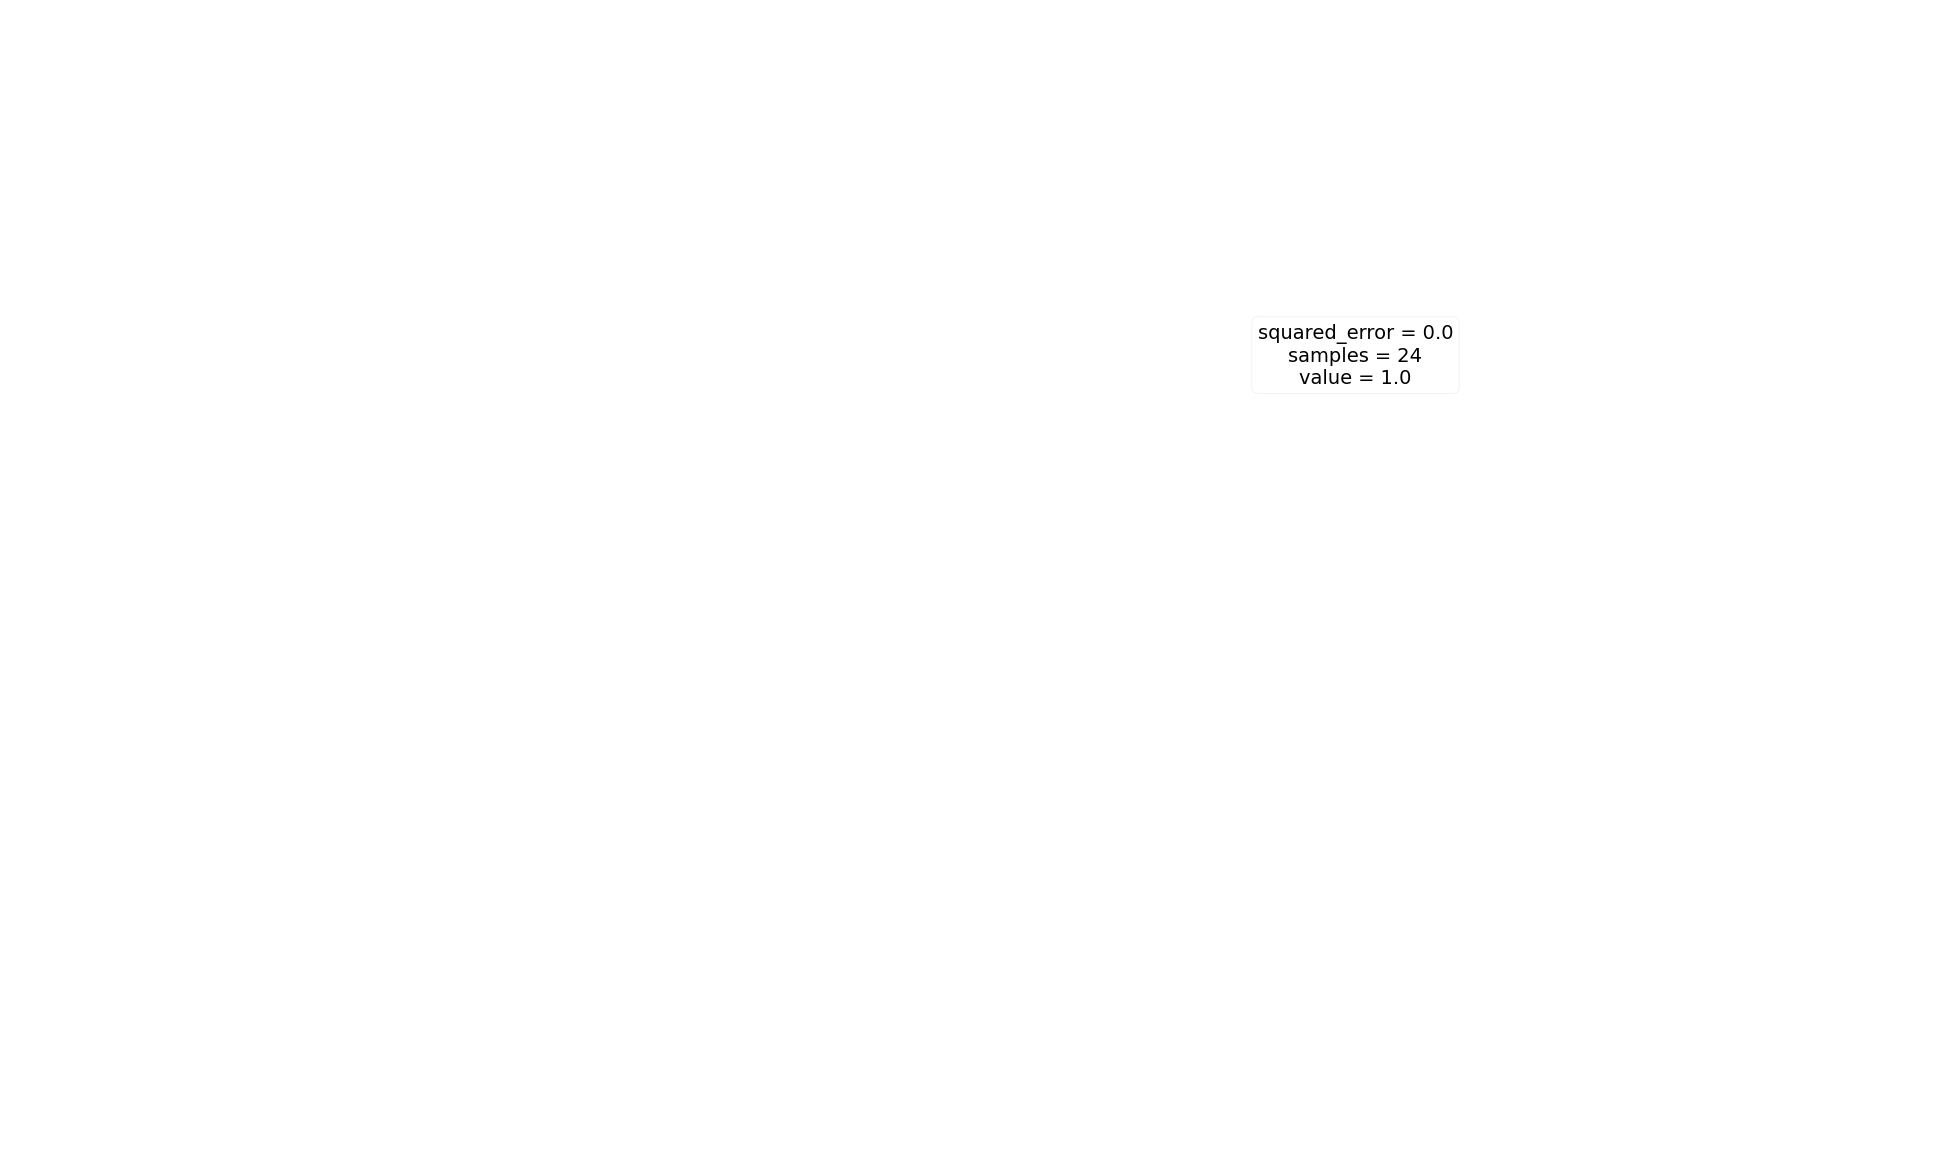

In [36]:
import pydot
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor(n_estimators = 100, random_state = 42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Pull out one tree from the forest
# Export the image to a dot file

Tree = regressor.estimators_[5]

plt.figure(figsize=(25,15))
tree.plot_tree(
    Tree,
    filled=True, 
    rounded=True, 
    fontsize=14
);

In [37]:
maxTrees, max_accuracy1 = calc_and_plot_trees()
print(f"max_trees = [{maxTrees}]")

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

In [ ]:
# maxFeatures = 57
maxFeatures, max_accuracy2 = calc_and_plot_features(df)
print(f"max_features1 = [{maxFeatures}]")

max_features1 = [18]


In [ ]:
if maxTrees & maxFeatures:
    rf_accuracy, rf_precision, rf_recall = get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, n_estimators=maxTrees, max_features=maxFeatures)
else:
    rf_accuracy, rf_precision, rf_recall = get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, n_estimators=75, max_features=57)    
log_reg_accuracy, log_reg_precision, log_reg_recall = get_scores(LogisticRegression, X_train, X_test, y_train, y_test)
decision_tree_accuracy, decision_tree_precision, decision_tree_recall = get_scores(DecisionTreeClassifier, X_train, X_test, y_train, y_test)
navie_bayes_accuracy, navie_bayes_precision, navie_bayes_recall = get_scores(GaussianNB, X_train, X_test, y_train, y_test)



print('_'*93, '\n|    > MODEL <         |    > Accuracy <      |    > Precision <     |     > Recall <        |', '\n', '_'*93)
print("| Random Forest        | ", rf_accuracy, ' | ', rf_precision,  ' | ', rf_recall, ' | ')
print("| Logistic Reg         | ", log_reg_accuracy, ' | ', log_reg_precision,  '                | ', log_reg_recall, ' |')
print("| Decision Tree        | ", decision_tree_accuracy, ' | ', decision_tree_precision,  ' | ', decision_tree_recall, ' |')
print("| Gaussian Naive Bayes | ", navie_bayes_accuracy, ' | ', navie_bayes_precision,  '| ', navie_bayes_recall, ' |')
print('_'*93)
print('\n\n', f"{'_ _'*34}", "\n")



if maxTrees & maxFeatures:
    print('_'*93, '\n|    > MODEL <         |    > Accuracy <      |    > Precision <     |     > Recall <        |', '\n', '_'*93)
    print("| Random Forest        | ", rf_accuracy, ' | ', rf_precision,  ' | ', rf_recall, ' | ')
    print('_'*93)
    plot_roc(X, y, RandomForestClassifier, 'Random_Forest', n_estimators=maxTrees, max_features=maxFeatures);
    print(f"{'_ _'*34}", "\n")
else:
    print('_'*93, '\n|    > MODEL <         |    > Accuracy <      |    > Precision <     |     > Recall <        |', '\n', '_'*93)
    print("| Random Forest        | ", rf_accuracy, ' | ', rf_precision,  ' | ', rf_recall, ' | ')
    print('_'*93)
    plot_roc(X, y, RandomForestClassifier, 'Random_Forest', n_estimators=75, max_features=57);
    print(f"{'_ _'*34}", "\n")


print('_'*93, '\n|    > MODEL <         |    > Accuracy <      |    > Precision <     |     > Recall <        |', '\n', '_'*93)
print("| Logistic Reg         | ", log_reg_accuracy, ' | ', log_reg_precision,  '                | ', log_reg_recall, ' |')
print('_'*93)
plot_roc(X, y, LogisticRegression, 'Logistic_Regression');
print(f"{'_ _'*34}", "\n")


print('_'*93, '\n|    > MODEL <         |    > Accuracy <      |    > Precision <     |     > Recall <        |', '\n', '_'*93)
print("| Decision Tree        | ", decision_tree_accuracy, ' | ', decision_tree_precision,  ' | ', decision_tree_recall, ' |')
print('_'*93)
plot_roc(X, y, DecisionTreeClassifier, 'Decision_Tree');
print(f"{'_ _'*34}", "\n")


print('_'*93, '\n|    > MODEL <         |    > Accuracy <      |    > Precision <     |     > Recall <        |', '\n', '_'*93)
print("| Gaussian Naive Bayes | ", navie_bayes_accuracy, ' | ', navie_bayes_precision,  '| ', navie_bayes_recall, ' |')
print('_'*93)
plot_roc(X, y, GaussianNB, 'Naive_Bayes')
print(f"{'_ _'*34}", "\n")

_____________________________________________________________________________________________ 
|    > MODEL <         |    > Accuracy <      |    > Precision <     |     > Recall <        | 
 _____________________________________________________________________________________________
| Random Forest        |  0.8363819095477387  |  0.6904761904761905  |  0.13211845102505695  | 
| Logistic Reg         |  0.8235175879396985  |  0.0                 |  0.0  |
| Decision Tree        |  0.725427135678392  |  0.2928692699490662  |  0.3929384965831435  |
| Gaussian Naive Bayes |  0.8207035175879397  |  0.4146341463414634 |  0.0387243735763098  |
_____________________________________________________________________________________________


 _ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _ 

_____________________________________________________________________________________________ 
|    > MODEL <         |    > Accuracy <      |    > Pre

_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _ 

_____________________________________________________________________________________________ 
|    > MODEL <         |    > Accuracy <      |    > Precision <     |     > Recall <        | 
 _____________________________________________________________________________________________
| Logistic Reg         |  0.8235175879396985  |  0.0                 |  0.0  |
_____________________________________________________________________________________________


_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _ 

_____________________________________________________________________________________________ 
|    > MODEL <         |    > Accuracy <      |    > Precision <     |     > Recall <        | 
 _____________________________________________________________________________________________
| Decision Tree        |  0.725427135678392  |  0.2928692699490662  |  0.3929384965831435  |
_____________________________________________________________________________________________


_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _ 

_____________________________________________________________________________________________ 
|    > MODEL <         |    > Accuracy <      |    > Precision <     |     > Recall <        | 
 _____________________________________________________________________________________________
| Gaussian Naive Bayes |  0.8207035175879397  |  0.4146341463414634 |  0.0387243735763098  |
_____________________________________________________________________________________________


_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _ 

